In [7]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import os

base = "Output/wav"
methods = [
    "noisy", "clean", "CNN", "CED", "RCED", "UNet", "ConvTasNet",
    "spectral_sub", "wiener", "mmse_lsa"
]
sr = 48000  # Adjust if different
waveforms = {}

for m in methods:
    path = os.path.join(base, f"{m}_p232_334.wav")
    waveform, _ = torchaudio.load(path)
    waveforms[m] = waveform.mean(dim=0)  # Ensure mono


In [8]:
min_len = min(w.shape[-1] for w in waveforms.values())
for k in waveforms:
    waveforms[k] = waveforms[k][:min_len]


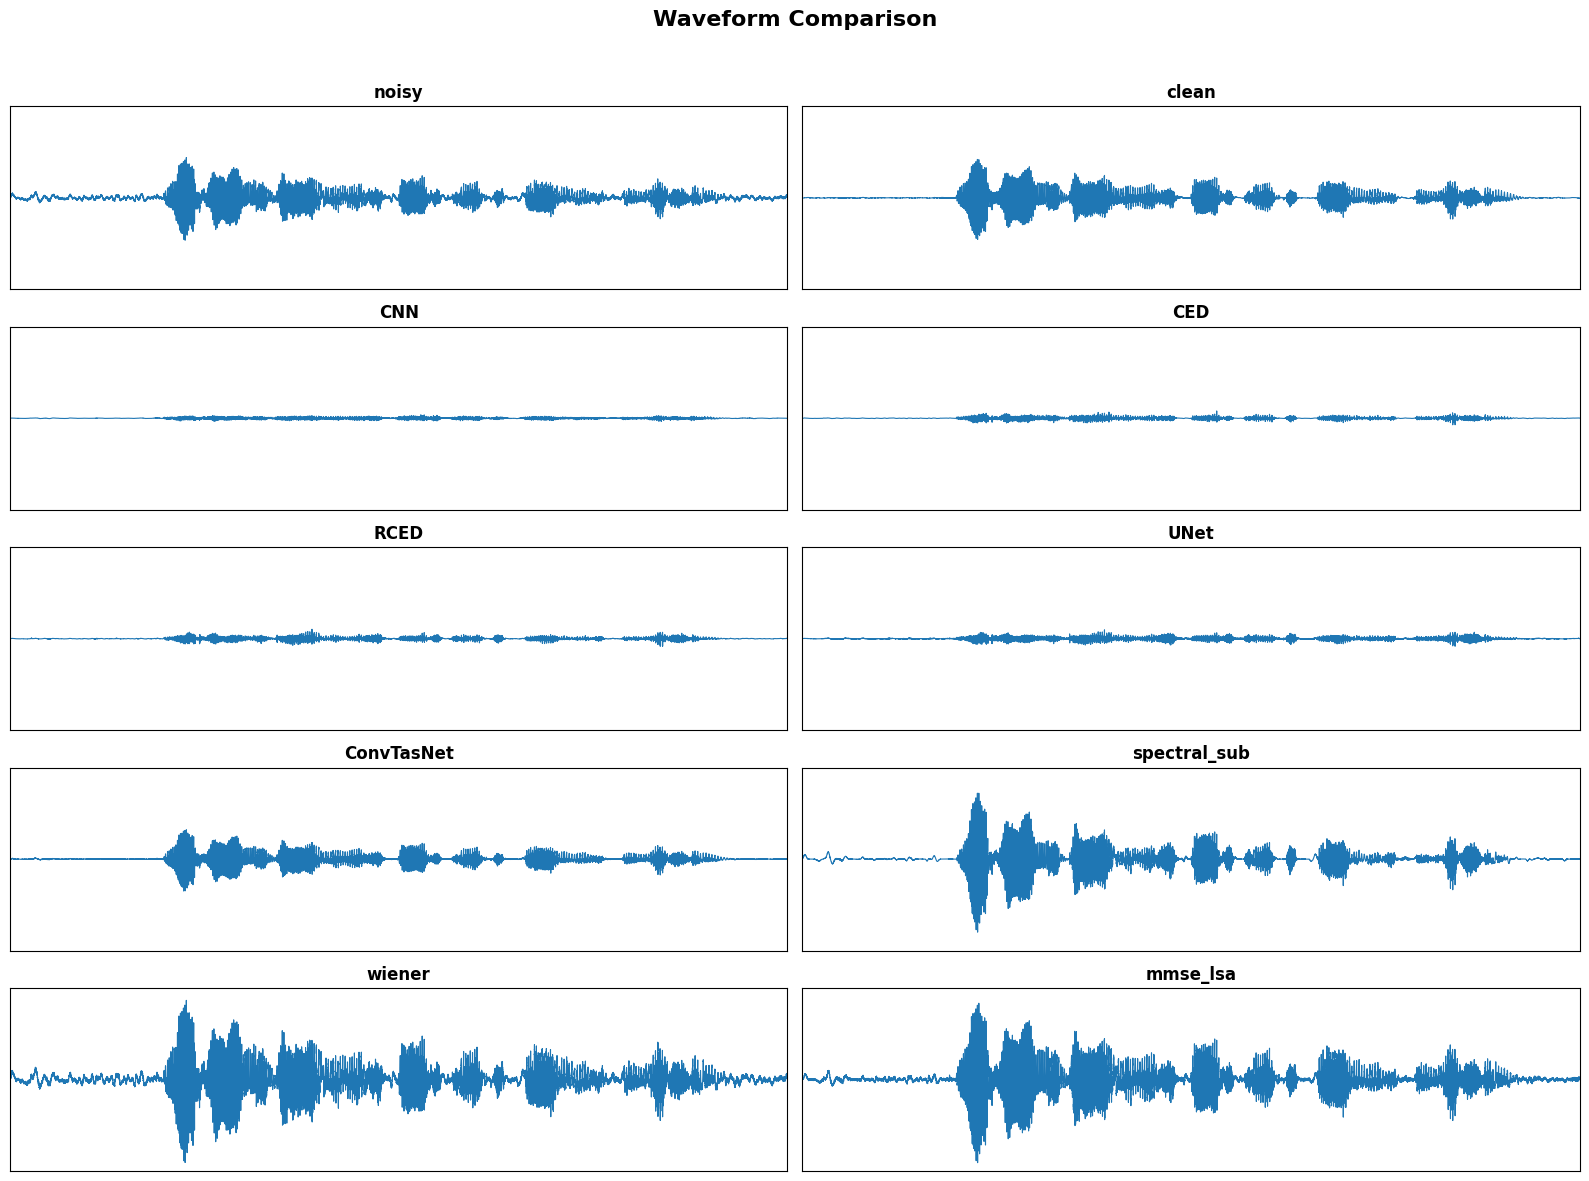

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
for i, method in enumerate(methods, 1):
    ax = plt.subplot(5, 2, i)
    ax.plot(waveforms[method].numpy(), linewidth=0.8)
    ax.set_title(f"{method}", fontsize=12, fontweight='bold')
    ax.set_xlim([0, len(waveforms[method])])
    ax.set_ylim([-1.1, 1.1])  # Set common y-scale for better comparison
    ax.set_xticks([]); ax.set_yticks([])  # Clean axis
    ax.grid(False)
plt.suptitle("Waveform Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


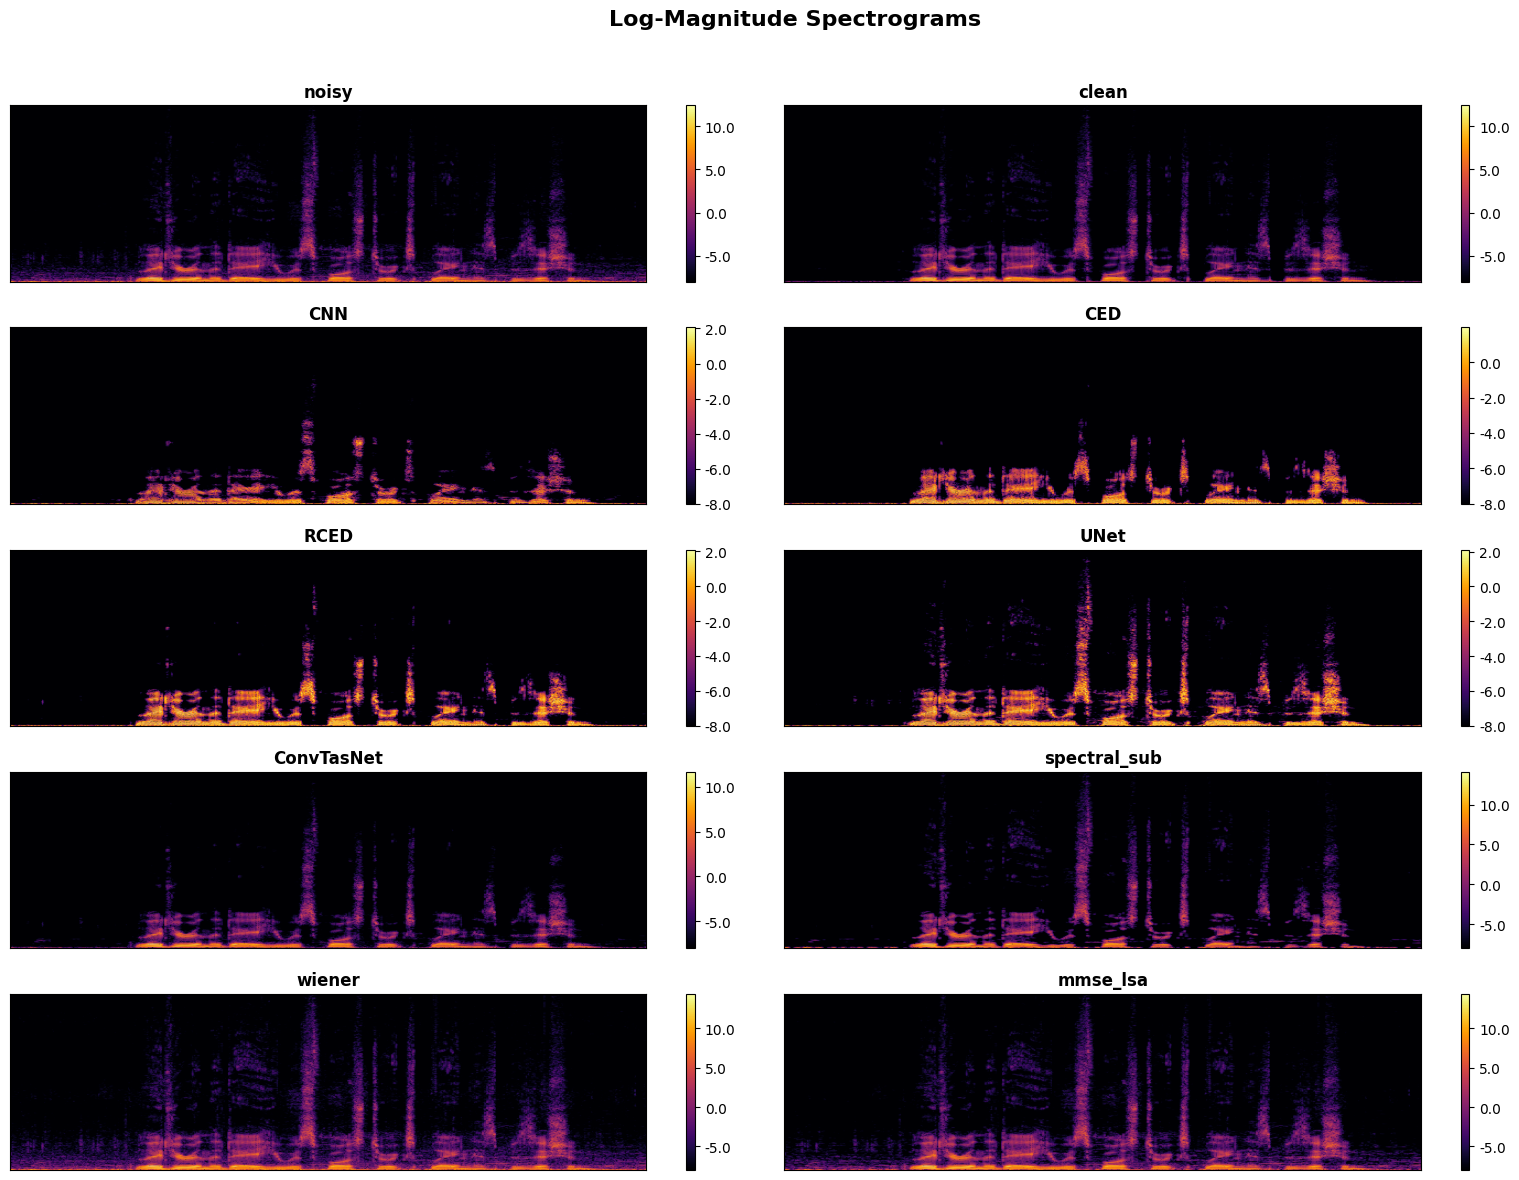

In [10]:
import torchaudio.transforms as T

spec_fn = T.Spectrogram(n_fft=1024, hop_length=256, power=2)

plt.figure(figsize=(16, 12))
for i, method in enumerate(methods, 1):
    spec = spec_fn(waveforms[method]).log2().clamp(min=-8)
    ax = plt.subplot(5, 2, i)
    im = ax.imshow(spec.numpy(), aspect='auto', origin='lower', cmap='inferno')
    ax.set_title(f"{method}", fontsize=12, fontweight='bold')
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax, format="%.1f")
plt.suptitle("Log-Magnitude Spectrograms", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
def manual_snr(clean, den):
    noise = clean - den
    return 10 * torch.log10(torch.mean(clean**2) / (torch.mean(noise**2) + 1e-9)).item()

def manual_mse(clean, den):
    return torch.mean((clean - den) ** 2).item()

for m in methods:
    if m != "clean":
        snr = manual_snr(waveforms["clean"], waveforms[m])
        mse = manual_mse(waveforms["clean"], waveforms[m])
        print(f"{m:14} | SNR: {snr:6.2f} dB | MSE: {mse:.6f}")


noisy          | SNR:  11.48 dB | MSE: 0.000308
CNN            | SNR:   0.37 dB | MSE: 0.003980
CED            | SNR:   0.77 dB | MSE: 0.003633
RCED           | SNR:   0.86 dB | MSE: 0.003554
UNet           | SNR:   0.87 dB | MSE: 0.003546
ConvTasNet     | SNR:  12.14 dB | MSE: 0.000265
spectral_sub   | SNR:   4.87 dB | MSE: 0.001412
wiener         | SNR:  -0.80 dB | MSE: 0.005209
mmse_lsa       | SNR:   0.05 dB | MSE: 0.004288


In [12]:
def spectral_flatness(x):
    mag = torch.abs(spec_fn(x))
    gmean = torch.exp(torch.mean(torch.log(mag + 1e-8)))
    amean = torch.mean(mag)
    return (gmean / (amean + 1e-8)).item()

for m in methods:
    flatness = spectral_flatness(waveforms[m])
    print(f"{m:14} | Spectral Flatness: {flatness:.4f}")


noisy          | Spectral Flatness: 0.0005
clean          | Spectral Flatness: 0.0001
CNN            | Spectral Flatness: 0.0001
CED            | Spectral Flatness: 0.0000
RCED           | Spectral Flatness: 0.0000
UNet           | Spectral Flatness: 0.0017
ConvTasNet     | Spectral Flatness: 0.0001
spectral_sub   | Spectral Flatness: 0.0000
wiener         | Spectral Flatness: 0.0005
mmse_lsa       | Spectral Flatness: 0.0002
